# Diffusion

Ce projet implémente un modèle pour la création d'image de type "Pixel Art" en 32×32 (prise du dataset https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art?resource=download&select=images).
L'objectif est de capturer la distribution complexe des couleurs et des structures géométriques propres à ce style visuel.

# Imports

In [9]:
import os, torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchvision import transforms

/opt/anaconda3/envs/data/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

On utilise 1000 étapes pour transformer un sprite en un nuage de points. On a réglé le moteur (via CUDA) pour que ça aille vite et que le passage du chaos à la clarté soit le plus fluide possible.

In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 16
CHANNELS = 3
T = 1000
LR = 1e-3
BATCH_SIZE = 64
CKPT_PATH = "pixel_art_model.pth"
NPY_PATH = 'data/sprites.npy'
LABELS_PATH = 'data/sprites_labels.npy'
NUM_CLASSES = 5

betas = torch.linspace(0.0001, 0.02, T).to(DEVICE)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

def get_val(vals, t, x_shape):
    """
    Args: vals (Tensor), t (Tensor), x_shape (tuple)
    Example: alpha_t = get_val(alphas, t, x.shape)
    Description: Récupère la valeur du schedule pour un batch donné sans conflit de device.
    Returns: Tensor
    """
    # On s'assure que t est sur le même device que vals (DEVICE)
    out = vals.gather(-1, t.to(vals.device)) 
    
    # On redimensionne pour le broadcasting (Batch, 1, 1, 1)
    return out.reshape(t.shape[0], *((1,) * (len(x_shape) - 1)))

# Chargement et Pretraitement des donnees


On utilise les fichiers sprites.npy et leurs étiquettes sprites_labels.npy. Le point clé ici a été de corriger les couleurs : on a appliqué une inversion via ImageOps pour éviter que les sprites ne sortent avec les mauvaises couleurs.
La mise à l'échelle vers l'intervalle [-1, 1] optimise la convergence en centrant la distribution des données.

In [11]:
class SpriteDataset(Dataset):
    """
    Args: img_file (str), label_file (str)
    Description: Chargeur de sprites 16x16 et leurs étiquettes associées.
    Returns: Tuple(Tensor, Tensor)
    """
    def __init__(self, img_file, label_file):
        self.data = np.load(img_file)
        self.labels = np.load(label_file)
        print(f"Dataset chargé : {self.data.shape[0]} images.")

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        img_tensor = torch.from_numpy(img).float().permute(2, 0, 1)
        img_tensor = (img_tensor / 255.0) * 2 - 1 
        
        # Inversion pour corriger l'effet négatif
        img_pil = Image.fromarray(img).convert("RGB")
        img_pil = ImageOps.invert(img_pil)
        img_tensor = transforms.ToTensor()(img_pil) * 2 - 1

        label = torch.tensor(self.labels[idx]).argmax() if self.labels[idx].ndim > 0 else torch.tensor(self.labels[idx])
        return img_tensor, label.long()

dataset = SpriteDataset(NPY_PATH, LABELS_PATH)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Dataset chargé : 89400 images.


# Architecture

Nous avons conçu un réseau de neurones spécifique pour cette tâche :

- Structure en Sablier : Le modèle compresse l'image puis la décompresse pour comprendre les formes globales et les détails.

- Conditionnement : Le modèle reçoit l'étape du temps et la classe de l'objet (épée, potion, etc.). Cela permet de piloter la génération au lieu d'avoir des résultats aléatoires.

- Lissage EMA : Nous utilisons une "moyenne mobile" des poids (EMA) pour la génération finale. Cette technique réduit le grain résiduel et stabilise les couleurs pour un rendu professionnel.

In [12]:
class BetterUNet(nn.Module):
    """
    Args: in_channels (int), num_classes (int)
    Example: model = BetterUNet()
    Description: UNet avec injection temporelle et conditionnement de classe.
    Returns: Tensor
    """
    def __init__(self, in_channels=3, num_classes=5):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(1, 32), nn.SiLU(), nn.Linear(32, 256))
        self.label_emb = nn.Embedding(num_classes, 256)
        
        self.inc = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.down1 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.down2 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        
        self.up1 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.up2 = nn.ConvTranspose2d(256, 64, 4, 2, 1)
        self.outc = nn.Conv2d(128, in_channels, 3, padding=1)

    def forward(self, x, t, y):
        t_emb = self.time_mlp(t.unsqueeze(-1).float() / T).unsqueeze(-1).unsqueeze(-1)
        y_emb = self.label_emb(y).unsqueeze(-1).unsqueeze(-1)
        
        x1 = F.silu(self.inc(x))
        x2 = F.silu(self.down1(x1))
        x3 = F.silu(self.down2(x2))
        
        h = x3 + t_emb + y_emb
        h = F.silu(self.up1(h))
        h = torch.cat([h, x2], dim=1) 
        h = F.silu(self.up2(h))
        h = torch.cat([h, x1], dim=1) 
        return self.outc(h)

class EMA:
    """
    Args: model (nn.Module), decay (float)
    Description: Gestion de la moyenne mobile exponentielle des poids.
    """
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {n: p.clone().detach() for n, p in model.named_parameters()}

    def update(self, model):
        for n, p in model.named_parameters():
            self.shadow[n] = self.decay * self.shadow[n] + (1 - self.decay) * p.detach()

# Instanciation

Entraîner une IA prend du temps, alors on a créé une sécurité avec le fichier best_pixel_art_model.pth.

In [13]:
model = BetterUNet(num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
ema = EMA(model)
start_epoch = 0

if os.path.exists(CKPT_PATH):
    print("Restauration du modèle...")
    checkpoint = torch.load(CKPT_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint['model'])
    ema.shadow = checkpoint['ema']
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint.get('epoch', 0)

Restauration du modèle...


/var/folders/d1/dk7prgk94r7gtwzh0c5xmw0m0000gn/T/ipykernel_43120/659287390.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CKPT_PATH, map_locatio

# Entraînement

C'est ici que l'apprentissage se produit. La fonction suit un protocole strict :

- Bruitage : On prend une image et on lui ajoute un bruit aléatoire.

-    Prédiction : Le modèle tente de prédire ce bruit.

-    Correction : On calcule l'écart (Loss MSE) entre sa prédiction et la réalité pour ajuster ses neurones.

-    Sauvegarde : À chaque époque, tout l'état (modèle, optimiseur, EMA) est sauvegardé dans best_pixel_art_model.pth pour éviter de tout perdre en cas d'arrêt

In [14]:
def run_training_loop(epochs=100,start_epoch=start_epoch):
    """
    Args: epochs (int)
    Example: run_training_loop(20)
    Description: Entraîne le modèle et sauvegarde les poids périodiquement.
    """
    model.train()
    if epochs <= start_epoch:
        print(f"Le modèle a déjà été entraîné jusqu'à l'époque {start_epoch}.")
    for epoch in range(start_epoch, epochs):
        pbar = tqdm(dataloader, desc=f"Époque {epoch}")
        for images, labels in pbar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            t = torch.randint(0, T, (images.shape[0],), device=DEVICE)
            noise = torch.randn_like(images)
            
            sqrt_ab = get_val(sqrt_alphas_cumprod, t, images.shape)
            sqrt_one_minus_ab = get_val(sqrt_one_minus_alphas_cumprod, t, images.shape)
            xt = sqrt_ab * images + sqrt_one_minus_ab * noise
            
            optimizer.zero_grad()
            noise_pred = model(xt, t, labels)
            loss = F.mse_loss(noise_pred, noise)
            loss.backward()
            optimizer.step()
            
            ema.update(model)
            pbar.set_postfix(loss=loss.item())
            
        torch.save({'model': model.state_dict(), 'ema': ema.shadow, 
                    'epoch': epoch + 1, 'optimizer': optimizer.state_dict()}, CKPT_PATH)
    start_epoch = max(epochs, start_epoch)

run_training_loop(50)

Le modèle a déjà été entraîné jusqu'à l'époque 50.


# Generation

Pour la livraison finale, on convertit les maths en images réelles. On utilise le clipping interne pour garder des couleurs naturelles. Comme nos sprites sont tout petits (16x16), on les agrandit avec l'algorithme NEAREST. On finit par générer un GIF pour voir, étape par étape, comment l'IA a "nettoyé" le bruit pour créer l'image.

Denoising: 100%|██████████| 1000/1000 [00:00<00:00, 1263.27it/s]


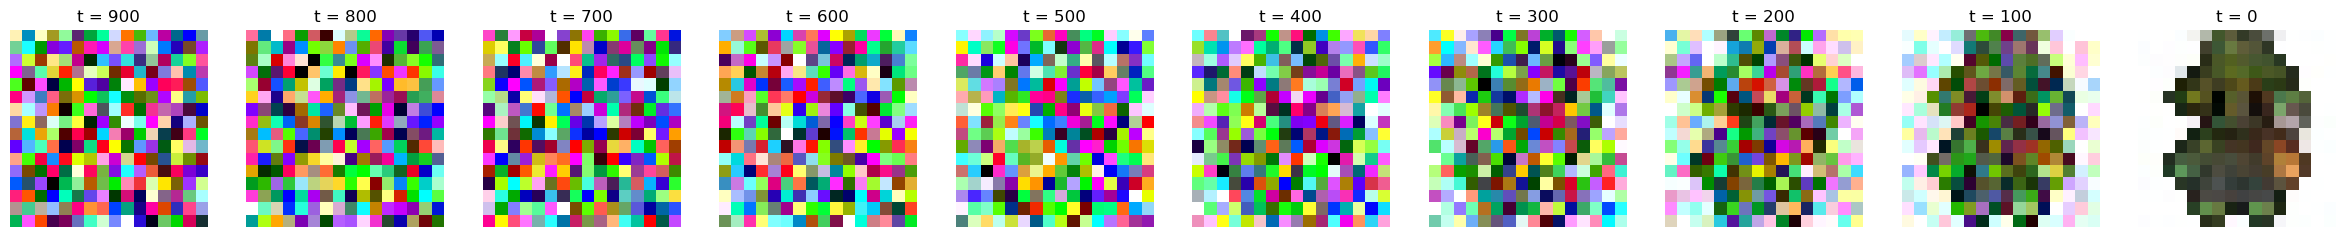

Denoising: 100%|██████████| 1000/1000 [00:00<00:00, 1301.66it/s]


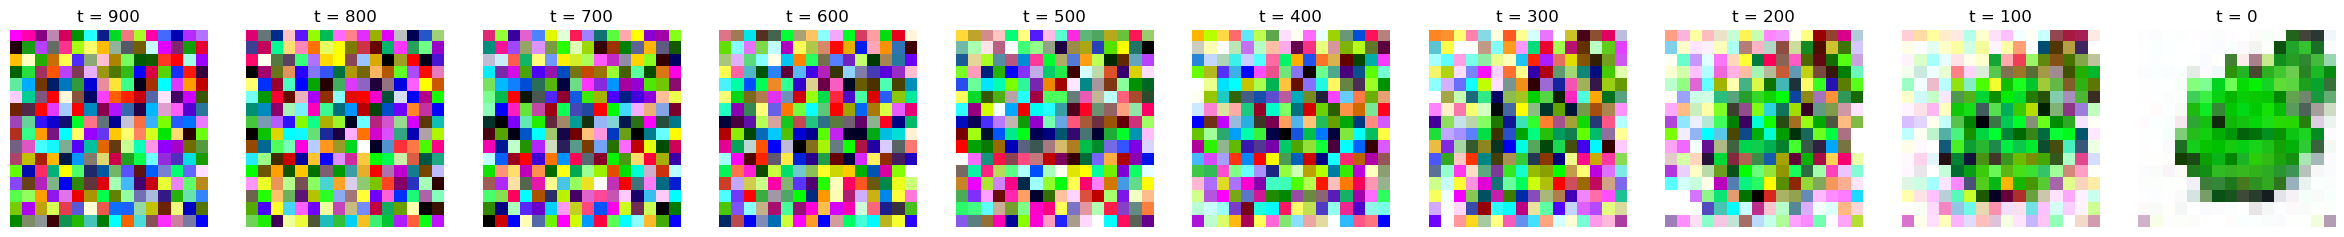

Denoising: 100%|██████████| 1000/1000 [00:00<00:00, 1257.42it/s]


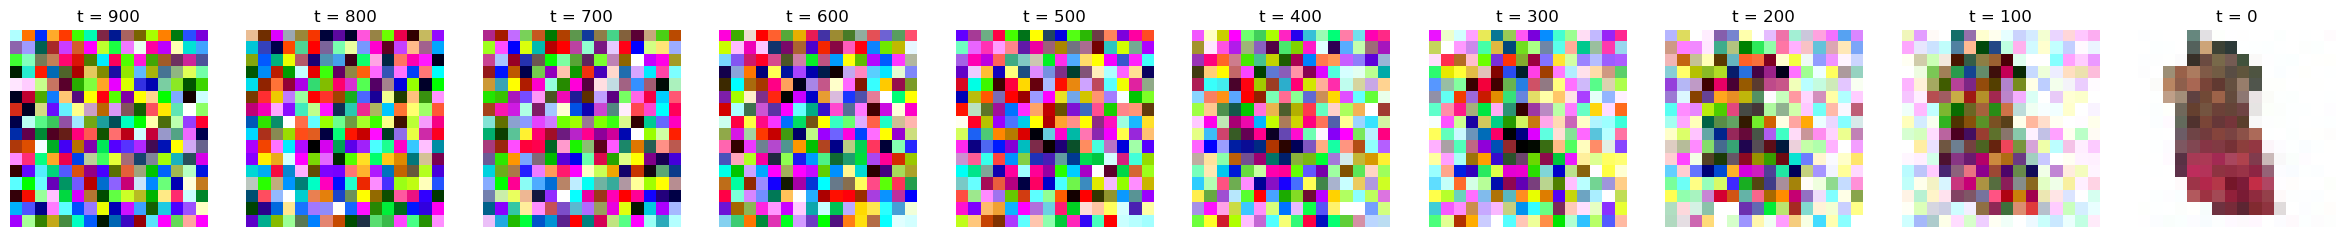

Denoising: 100%|██████████| 1000/1000 [00:00<00:00, 1254.31it/s]


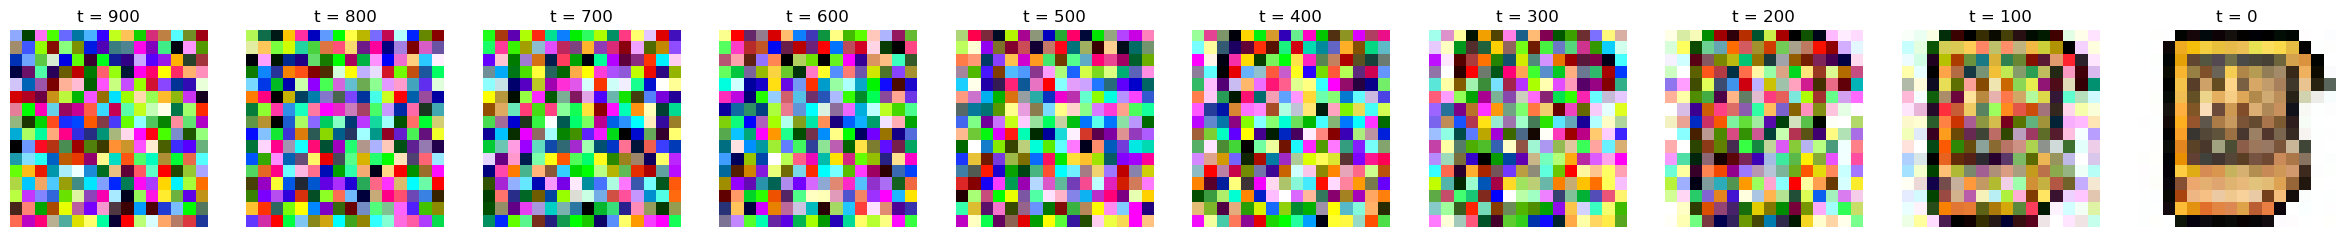

Denoising: 100%|██████████| 1000/1000 [00:00<00:00, 1248.38it/s]


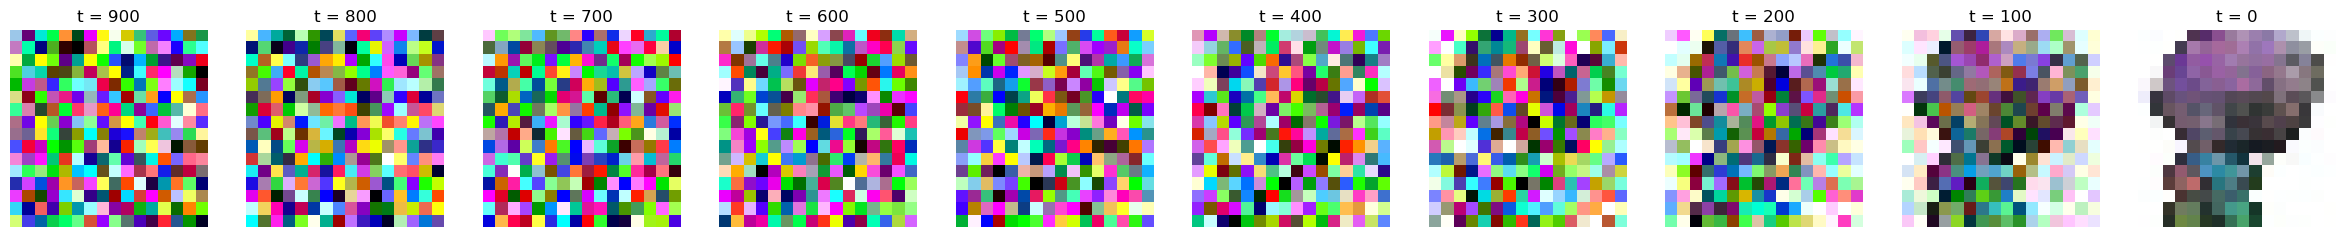

In [15]:
@torch.no_grad()
def generate_with_snapshots(class_id=0, filename="evolution.gif", interval=100):
    """
    Args: class_id (int), filename (str), interval (int)
    Example: generate_with_snapshots(class_id=1)
    Description: Synthétise un sprite et capture les étapes de débruitage.
    """
    model.eval()
    frames, snapshots, times = [], [], []
    upscale = 8
    xt = torch.randn(1, CHANNELS, IMG_SIZE, IMG_SIZE).to(DEVICE)
    y = torch.tensor([class_id], device=DEVICE)
    
    for t in tqdm(reversed(range(T)), total=T, desc="Denoising"):
        t_tensor = torch.tensor([t], device=DEVICE)
        noise_pred = model(xt, t_tensor, y)
        
        alpha_t, alpha_bar_t = alphas[t], alphas_cumprod[t]
        x0_pred = ((xt - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)).clamp(-1, 1)
        noise_pred = (xt - torch.sqrt(alpha_bar_t) * x0_pred) / torch.sqrt(1 - alpha_bar_t)
        
        z = torch.randn_like(xt) if t > 0 else 0
        xt = (1 / torch.sqrt(alpha_t)) * (xt - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * noise_pred) + torch.sqrt(betas[t]) * z
        
        img_data = ((xt[0].clamp(-1, 1) + 1) / 2 * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
        pil_img = ImageOps.invert(Image.fromarray(img_data))
        
        frames.append(pil_img.resize((IMG_SIZE * upscale, IMG_SIZE * upscale), Image.NEAREST))
        if t % interval == 0 or t == 0:
            snapshots.append(pil_img)
            times.append(t)

    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=20, loop=0)
    
    fig, axes = plt.subplots(1, len(snapshots), figsize=(len(snapshots)*3, 3))
    for i, (snap, time) in enumerate(zip(snapshots, times)):
        axes[i].imshow(snap, interpolation='nearest')
        axes[i].set_title(f"t = {time}")
        axes[i].axis('off')
    plt.show()

for class_id in range(NUM_CLASSES):
    generate_with_snapshots(class_id=class_id)

## Génération de GIF Pixel par Pixel

Cette section génère des GIF animés montrant le processus complet de débruitage, avec des options pour capturer chaque étape ou des intervalles spécifiques.

In [26]:
import imageio
from PIL import Image, ImageDraw, ImageFont, ImageOps

@torch.no_grad()
def generate_gif_denoising(class_id=0, filename="denoising_process.gif", 
                           capture_every=1, upscale_factor=8, 
                           fps=10, show_progress_bar=True):
    """
    Génère un GIF montrant le processus complet de débruitage pixel par pixel.
    
    Args:
        class_id (int): Classe du sprite à générer (0-4)
        filename (str): Nom du fichier GIF de sortie
        capture_every (int): Capturer une frame tous les N pas (1 = toutes les étapes)
        upscale_factor (int): Facteur d'agrandissement de l'image
        fps (int): Images par seconde dans le GIF
        show_progress_bar (bool): Afficher la barre de progression
    
    Returns:
        PIL.Image: Image finale générée
    """
    model.eval()
    frames = []
    
    # Initialisation avec du bruit pur
    xt = torch.randn(1, CHANNELS, IMG_SIZE, IMG_SIZE).to(DEVICE)
    y = torch.tensor([class_id], device=DEVICE)
    
    # Processus de débruitage
    iterator = reversed(range(T))
    if show_progress_bar:
        iterator = tqdm(list(iterator), total=T, desc=f"Génération classe {class_id}")
    
    for step_idx, t in enumerate(iterator):
        t_tensor = torch.tensor([t], device=DEVICE)
        
        # Prédiction du bruit
        noise_pred = model(xt, t_tensor, y)
        
        # Calcul de x0 (prédiction de l'image originale)
        alpha_t, alpha_bar_t = alphas[t], alphas_cumprod[t]
        x0_pred = ((xt - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)).clamp(-1, 1)
        
        # Recalcul du bruit pour stabilité
        noise_pred = (xt - torch.sqrt(alpha_bar_t) * x0_pred) / torch.sqrt(1 - alpha_bar_t)
        
        # Échantillonnage du bruit pour le pas suivant
        z = torch.randn_like(xt) if t > 0 else 0
        
        # Mise à jour de l'image
        xt = (1 / torch.sqrt(alpha_t)) * (xt - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * noise_pred) + torch.sqrt(betas[t]) * z
        
        # Capturer la frame tous les N pas
        if step_idx % capture_every == 0 or t == 0:
            # Conversion en image PIL
            img_data = ((xt[0].clamp(-1, 1) + 1) / 2 * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
            pil_img = ImageOps.invert(Image.fromarray(img_data))
            
            # Agrandissement
            upscaled = pil_img.resize(
                (IMG_SIZE * upscale_factor, IMG_SIZE * upscale_factor), 
                Image.NEAREST
            )
            
            # Ajouter un texte avec le numéro de pas
            draw = ImageDraw.Draw(upscaled)
            text = f"t={t}/{T-1} | étape {T-t}/{T}"
            
            # Utiliser une police par défaut
            try:
                # Essayer de charger une police
                font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 12)
            except:
                font = ImageFont.load_default()
            
            # Dessiner le texte avec un fond pour la lisibilité
            text_bbox = draw.textbbox((0, 0), text, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            
            # Rectangle de fond
            draw.rectangle(
                [(0, 0), (text_width + 10, text_height + 10)],
                fill=(255, 255, 255, 200)
            )
            draw.text((5, 5), text, fill=(0, 0, 0), font=font)
            
            frames.append(upscaled)
    
    # Ajouter une pause de 5 secondes à la fin (dupliquer la dernière frame)
    pause_frames = int(fps * 5)  # 5 secondes de pause
    if len(frames) > 0:
        last_frame = frames[-1]
        for _ in range(pause_frames):
            frames.append(last_frame.copy())
    
    # Sauvegarder le GIF
    duration_ms = int(1000 / fps)
    frames[0].save(
        filename, 
        save_all=True, 
        append_images=frames[1:], 
        duration=duration_ms, 
        loop=0,
        optimize=False
    )
    
    print(f"✓ GIF sauvegardé: {filename}")
    print(f"  - Nombre de frames: {len(frames)} (dont {pause_frames} frames de pause)")
    print(f"  - Durée: {len(frames) * duration_ms / 1000:.2f}s (avec 5s de pause finale)")
    print(f"  - Résolution: {IMG_SIZE * upscale_factor}x{IMG_SIZE * upscale_factor}")
    
    return pil_img  # Retourner l'image finale

In [21]:
@torch.no_grad()
def generate_comparison_gif(class_id=0, filename="comparison.gif", 
                            num_snapshots=10, upscale_factor=8):
    """
    Génère un GIF avec une comparaison côte à côte de plusieurs étapes clés.
    
    Args:
        class_id (int): Classe du sprite à générer
        filename (str): Nom du fichier GIF de sortie
        num_snapshots (int): Nombre d'instantanés à capturer
        upscale_factor (int): Facteur d'agrandissement
    
    Returns:
        list: Liste des images à différentes étapes
    """
    model.eval()
    snapshots = []
    snapshot_times = []
    
    # Calculer les pas à capturer (uniformément espacés)
    capture_steps = np.linspace(T-1, 0, num_snapshots).astype(int)
    
    # Initialisation
    xt = torch.randn(1, CHANNELS, IMG_SIZE, IMG_SIZE).to(DEVICE)
    y = torch.tensor([class_id], device=DEVICE)
    
    for t in tqdm(reversed(range(T)), total=T, desc=f"Comparaison classe {class_id}"):
        t_tensor = torch.tensor([t], device=DEVICE)
        noise_pred = model(xt, t_tensor, y)
        
        alpha_t, alpha_bar_t = alphas[t], alphas_cumprod[t]
        x0_pred = ((xt - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)).clamp(-1, 1)
        noise_pred = (xt - torch.sqrt(alpha_bar_t) * x0_pred) / torch.sqrt(1 - alpha_bar_t)
        
        z = torch.randn_like(xt) if t > 0 else 0
        xt = (1 / torch.sqrt(alpha_t)) * (xt - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * noise_pred) + torch.sqrt(betas[t]) * z
        
        # Capturer les snapshots aux étapes spécifiées
        if t in capture_steps or t == 0:
            img_data = ((xt[0].clamp(-1, 1) + 1) / 2 * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
            pil_img = ImageOps.invert(Image.fromarray(img_data))
            snapshots.append(pil_img)
            snapshot_times.append(t)
    
    # Créer une grille d'images pour comparaison
    img_size = IMG_SIZE * upscale_factor
    grid_cols = min(5, len(snapshots))
    grid_rows = (len(snapshots) + grid_cols - 1) // grid_cols
    
    grid_width = img_size * grid_cols + 10 * (grid_cols + 1)
    grid_height = img_size * grid_rows + 40 * grid_rows + 20
    
    comparison = Image.new('RGB', (grid_width, grid_height), color=(255, 255, 255))
    draw = ImageDraw.Draw(comparison)
    
    try:
        font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 14)
        font_small = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 10)
    except:
        font = ImageFont.load_default()
        font_small = font
    
    for idx, (img, t_val) in enumerate(zip(snapshots, snapshot_times)):
        row = idx // grid_cols
        col = idx % grid_cols
        
        x_pos = 10 + col * (img_size + 10)
        y_pos = 30 + row * (img_size + 40)
        
        # Agrandir et coller l'image
        upscaled = img.resize((img_size, img_size), Image.NEAREST)
        comparison.paste(upscaled, (x_pos, y_pos))
        
        # Ajouter le label
        label = f"t={t_val}"
        text_bbox = draw.textbbox((0, 0), label, font=font_small)
        text_width = text_bbox[2] - text_bbox[0]
        draw.text((x_pos + img_size // 2 - text_width // 2, y_pos - 20), 
                  label, fill=(0, 0, 0), font=font_small)
    
    # Titre
    title = f"Évolution du débruitage - Classe {class_id}"
    title_bbox = draw.textbbox((0, 0), title, font=font)
    title_width = title_bbox[2] - title_bbox[0]
    draw.text((grid_width // 2 - title_width // 2, 5), title, fill=(0, 0, 0), font=font)
    
    comparison.save(filename.replace('.gif', '_comparison.png'))
    print(f"✓ Comparaison sauvegardée: {filename.replace('.gif', '_comparison.png')}")
    
    return snapshots

### Exemples d'utilisation

Voici différentes façons de générer des GIFs pour visualiser le processus de génération.

Génération classe 0: 100%|██████████| 1000/1000 [00:00<00:00, 1044.26it/s]


✓ GIF sauvegardé: sprite_classe_0_rapide.gif
  - Nombre de frames: 141 (dont 40 frames de pause)
  - Durée: 17.62s (avec 5s de pause finale)
  - Résolution: 480x480


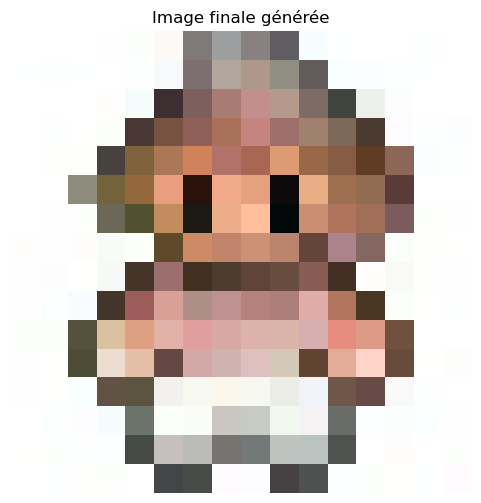

In [29]:
# Exemple 1: Générer un GIF détaillé avec toutes les étapes (lent mais complet)
# generate_gif_denoising(
#     class_id=0, 
#     filename="sprite_classe_0_complet.gif",
#     capture_every=1,  # Capture chaque étape
#     upscale_factor=8,
#     fps=30
# )

# Exemple 2: Générer un GIF (capture tous les 10 pas pour un fichier plus léger)
final_img = generate_gif_denoising(
    class_id=0, 
    filename="sprite_classe_0_rapide.gif",
    capture_every=10,  # Capture tous les 10 pas
    upscale_factor=30,  # GIF plus grand pour une meilleure visualisation
    fps=8  # FPS réduit pour mieux apprécier le processus
)

# Afficher l'image finale
plt.figure(figsize=(6, 6))
plt.imshow(final_img, interpolation='nearest')
plt.title("Image finale générée")
plt.axis('off')
plt.show()

In [ ]:
# Exemple 3: Générer une image de comparaison avec plusieurs étapes clés
snapshots = generate_comparison_gif(
    class_id=0,
    filename="sprite_classe_0.gif",
    num_snapshots=12,
    upscale_factor=12  # Plus grand pour mieux voir les détails
)

Comparaison classe 0: 100%|██████████| 1000/1000 [00:00<00:00, 1097.10it/s]

✓ Comparaison sauvegardée: sprite_classe_0_comparison.png


In [ ]:
# Exemple 4: Générer des GIFs pour toutes les classes
for class_id in range(NUM_CLASSES):
    print(f"\n{'='*50}")
    print(f"Génération pour la classe {class_id}")
    print('='*50)
    
    # GIF animé
    generate_gif_denoising(
        class_id=class_id,
        filename=f"sprite_classe_{class_id}_animation.gif",
        capture_every=5,  # Balance entre qualité et taille du fichier
        upscale_factor=12,  # GIF plus grand
        fps=8  # Vitesse lente pour apprécier le débruitage
    )
    
    # Image de comparaison
    generate_comparison_gif(
        class_id=class_id,
        filename=f"sprite_classe_{class_id}.gif",
        num_snapshots=10,
        upscale_factor=12  # Plus grand pour mieux voir
    )


Génération pour la classe 0


Génération classe 0: 100%|██████████| 1000/1000 [00:00<00:00, 1114.34it/s]


✓ GIF sauvegardé: sprite_classe_0_animation.gif
  - Nombre de frames: 201
  - Durée: 8.04s
  - Résolution: 128x128


Comparaison classe 0: 100%|██████████| 1000/1000 [00:01<00:00, 953.16it/s]


✓ Comparaison sauvegardée: sprite_classe_0_comparison.png

Génération pour la classe 1


Génération classe 1: 100%|██████████| 1000/1000 [00:01<00:00, 907.77it/s]


✓ GIF sauvegardé: sprite_classe_1_animation.gif
  - Nombre de frames: 201
  - Durée: 8.04s
  - Résolution: 128x128


Comparaison classe 1: 100%|██████████| 1000/1000 [00:00<00:00, 1156.74it/s]


✓ Comparaison sauvegardée: sprite_classe_1_comparison.png

Génération pour la classe 2


Génération classe 2: 100%|██████████| 1000/1000 [00:01<00:00, 926.33it/s]


✓ GIF sauvegardé: sprite_classe_2_animation.gif
  - Nombre de frames: 201
  - Durée: 8.04s
  - Résolution: 128x128


Comparaison classe 2: 100%|██████████| 1000/1000 [00:00<00:00, 1244.19it/s]


✓ Comparaison sauvegardée: sprite_classe_2_comparison.png

Génération pour la classe 3


Génération classe 3: 100%|██████████| 1000/1000 [00:01<00:00, 872.97it/s]


✓ GIF sauvegardé: sprite_classe_3_animation.gif
  - Nombre de frames: 201
  - Durée: 8.04s
  - Résolution: 128x128


Comparaison classe 3: 100%|██████████| 1000/1000 [00:00<00:00, 1338.91it/s]


✓ Comparaison sauvegardée: sprite_classe_3_comparison.png

Génération pour la classe 4


Génération classe 4: 100%|██████████| 1000/1000 [00:00<00:00, 1003.17it/s]


✓ GIF sauvegardé: sprite_classe_4_animation.gif
  - Nombre de frames: 201
  - Durée: 8.04s
  - Résolution: 128x128


Comparaison classe 4: 100%|██████████| 1000/1000 [00:00<00:00, 1153.70it/s]

✓ Comparaison sauvegardée: sprite_classe_4_comparison.png


# Métriques et Visualisations

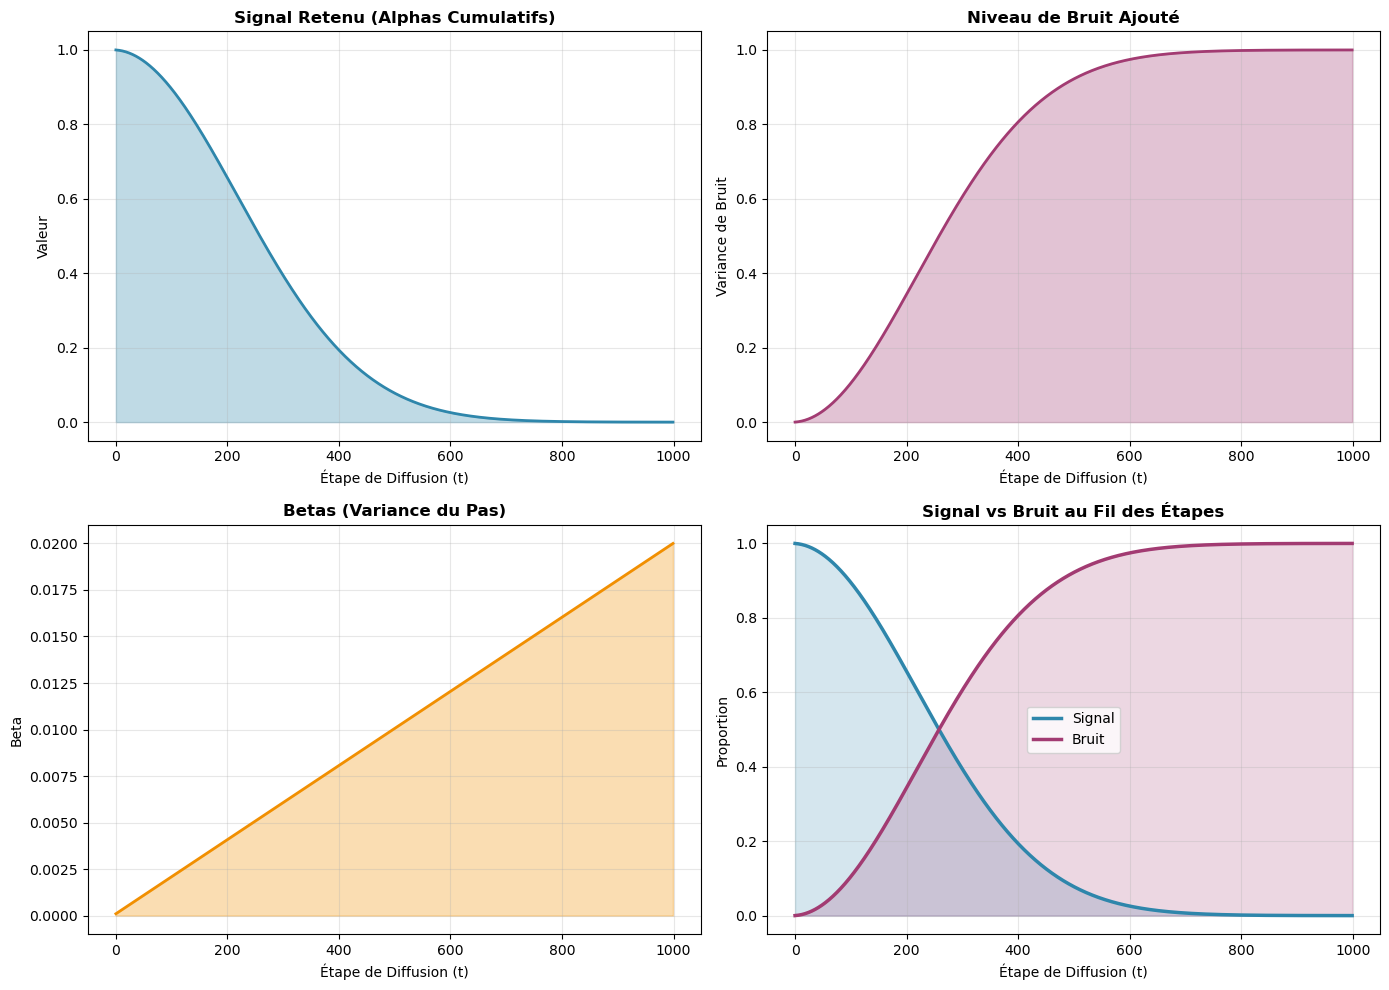

✓ Graphique du schedule de diffusion sauvegardé: metrics_diffusion_schedule.png


In [30]:
import seaborn as sns

# ==================== MÉTRIQUE 1: Schedule du Bruit ====================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Alphas cumulatifs (progression du signal)
t_range = np.arange(T)
axes[0, 0].plot(t_range, alphas_cumprod.cpu().numpy(), linewidth=2, color='#2E86AB')
axes[0, 0].fill_between(t_range, alphas_cumprod.cpu().numpy(), alpha=0.3, color='#2E86AB')
axes[0, 0].set_title('Signal Retenu (Alphas Cumulatifs)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Étape de Diffusion (t)')
axes[0, 0].set_ylabel('Valeur')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Bruit progressif
noise_level = (1 - alphas_cumprod.cpu().numpy())
axes[0, 1].plot(t_range, noise_level, linewidth=2, color='#A23B72')
axes[0, 1].fill_between(t_range, noise_level, alpha=0.3, color='#A23B72')
axes[0, 1].set_title('Niveau de Bruit Ajouté', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Étape de Diffusion (t)')
axes[0, 1].set_ylabel('Variance de Bruit')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Betas (variance du pas)
axes[1, 0].plot(t_range, betas.cpu().numpy(), linewidth=2, color='#F18F01')
axes[1, 0].fill_between(t_range, betas.cpu().numpy(), alpha=0.3, color='#F18F01')
axes[1, 0].set_title('Betas (Variance du Pas)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Étape de Diffusion (t)')
axes[1, 0].set_ylabel('Beta')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Comparaison Signal vs Bruit
axes[1, 1].plot(t_range, alphas_cumprod.cpu().numpy(), label='Signal', linewidth=2.5, color='#2E86AB')
axes[1, 1].plot(t_range, noise_level, label='Bruit', linewidth=2.5, color='#A23B72')
axes[1, 1].fill_between(t_range, alphas_cumprod.cpu().numpy(), alpha=0.2, color='#2E86AB')
axes[1, 1].fill_between(t_range, noise_level, alpha=0.2, color='#A23B72')
axes[1, 1].set_title('Signal vs Bruit au Fil des Étapes', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Étape de Diffusion (t)')
axes[1, 1].set_ylabel('Proportion')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_diffusion_schedule.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Graphique du schedule de diffusion sauvegardé: metrics_diffusion_schedule.png")

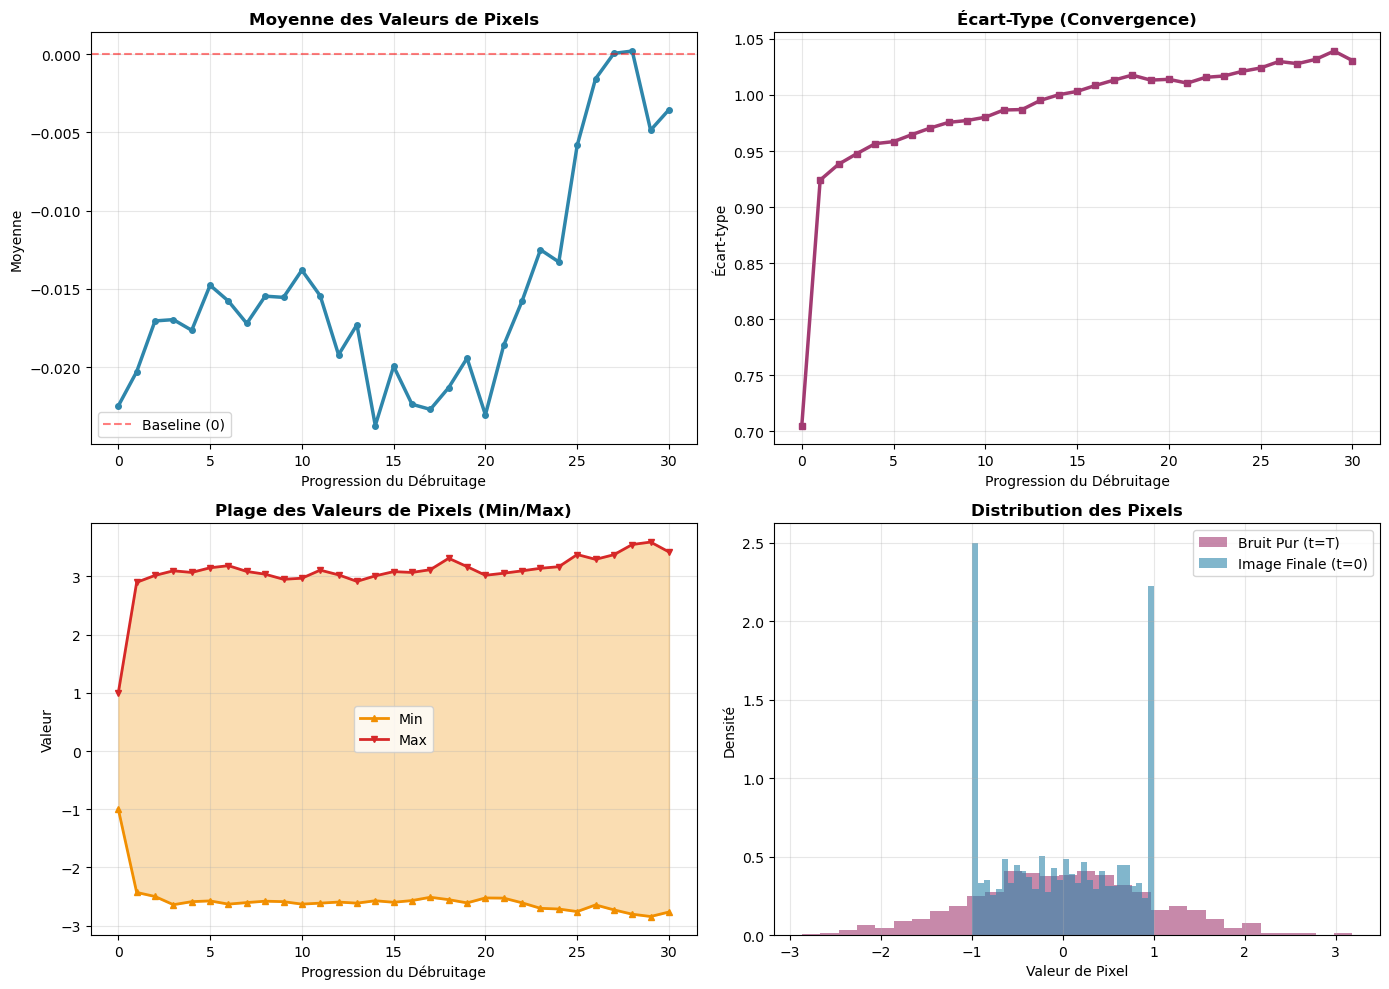

✓ Graphique du processus de débruitage sauvegardé: metrics_denoising_process.png


In [31]:
# ==================== MÉTRIQUE 2: Processus de Débruitage ====================
# Simuler le processus de débruitage et capturer les statistiques

@torch.no_grad()
def analyze_denoising_process(class_id=0, num_steps=50):
    """Analyse le processus de débruitage et collecte les statistiques."""
    model.eval()
    
    xt = torch.randn(1, CHANNELS, IMG_SIZE, IMG_SIZE).to(DEVICE)
    y = torch.tensor([class_id], device=DEVICE)
    
    stats = {
        'mean': [],
        'std': [],
        'min': [],
        'max': [],
        't_values': []
    }
    
    step_size = T // num_steps
    
    for t in reversed(range(0, T, step_size)):
        t_tensor = torch.tensor([t], device=DEVICE)
        noise_pred = model(xt, t_tensor, y)
        
        alpha_t, alpha_bar_t = alphas[t], alphas_cumprod[t]
        x0_pred = ((xt - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)).clamp(-1, 1)
        noise_pred = (xt - torch.sqrt(alpha_bar_t) * x0_pred) / torch.sqrt(1 - alpha_bar_t)
        
        z = torch.randn_like(xt) if t > 0 else 0
        xt = (1 / torch.sqrt(alpha_t)) * (xt - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * noise_pred) + torch.sqrt(betas[t]) * z
        
        # Collecter les statistiques
        xt_np = xt[0].detach().cpu().numpy()
        stats['mean'].append(np.mean(xt_np))
        stats['std'].append(np.std(xt_np))
        stats['min'].append(np.min(xt_np))
        stats['max'].append(np.max(xt_np))
        stats['t_values'].append(t)
    
    return stats, xt

stats, final_tensor = analyze_denoising_process(class_id=0, num_steps=30)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Inverser les listes pour afficher du début à la fin
t_axis = list(reversed(stats['t_values']))
mean_vals = list(reversed(stats['mean']))
std_vals = list(reversed(stats['std']))
min_vals = list(reversed(stats['min']))
max_vals = list(reversed(stats['max']))

# Plot 1: Moyenne au fil du temps
axes[0, 0].plot(range(len(mean_vals)), mean_vals, marker='o', linewidth=2.5, color='#2E86AB', markersize=4)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Baseline (0)')
axes[0, 0].set_title('Moyenne des Valeurs de Pixels', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Progression du Débruitage')
axes[0, 0].set_ylabel('Moyenne')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Écart-type (convergence)
axes[0, 1].plot(range(len(std_vals)), std_vals, marker='s', linewidth=2.5, color='#A23B72', markersize=4)
axes[0, 1].set_title('Écart-Type (Convergence)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Progression du Débruitage')
axes[0, 1].set_ylabel('Écart-type')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Plage des valeurs (min/max)
axes[1, 0].fill_between(range(len(min_vals)), min_vals, max_vals, alpha=0.3, color='#F18F01')
axes[1, 0].plot(range(len(min_vals)), min_vals, marker='^', label='Min', linewidth=2, color='#F18F01', markersize=4)
axes[1, 0].plot(range(len(max_vals)), max_vals, marker='v', label='Max', linewidth=2, color='#D62828', markersize=4)
axes[1, 0].set_title('Plage des Valeurs de Pixels (Min/Max)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Progression du Débruitage')
axes[1, 0].set_ylabel('Valeur')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Distribution finale vs bruitée
noise_img = torch.randn(1, CHANNELS, IMG_SIZE, IMG_SIZE).cpu().numpy().flatten()
final_img_np = final_tensor.cpu().numpy().flatten()

axes[1, 1].hist(noise_img, bins=30, alpha=0.6, label='Bruit Pur (t=T)', color='#A23B72', density=True)
axes[1, 1].hist(final_img_np, bins=30, alpha=0.6, label='Image Finale (t=0)', color='#2E86AB', density=True)
axes[1, 1].set_title('Distribution des Pixels', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Valeur de Pixel')
axes[1, 1].set_ylabel('Densité')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('metrics_denoising_process.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Graphique du processus de débruitage sauvegardé: metrics_denoising_process.png")

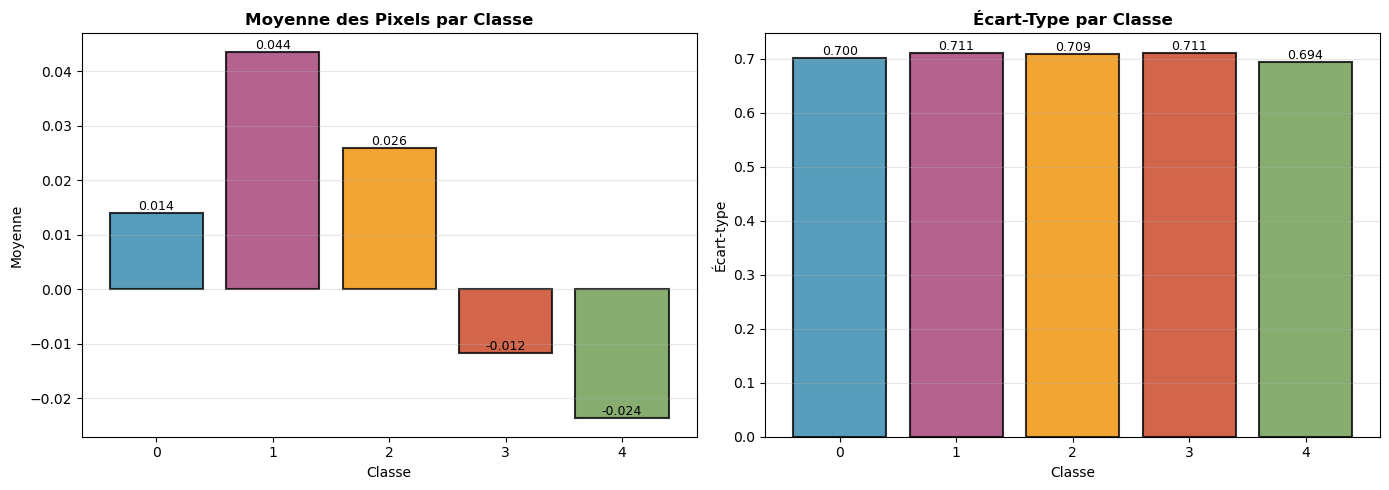

✓ Graphique de comparaison par classe sauvegardé: metrics_class_comparison.png


In [32]:
# ==================== MÉTRIQUE 3: Comparaison par Classe ====================

@torch.no_grad()
def get_class_statistics():
    """Génère et compare les statistiques pour chaque classe."""
    model.eval()
    class_stats = {i: {'mean': [], 'std': []} for i in range(NUM_CLASSES)}
    
    for class_id in range(NUM_CLASSES):
        xt = torch.randn(1, CHANNELS, IMG_SIZE, IMG_SIZE).to(DEVICE)
        y = torch.tensor([class_id], device=DEVICE)
        
        for t in reversed(range(0, T, T // 10)):  # 10 points d'échantillonnage
            t_tensor = torch.tensor([t], device=DEVICE)
            noise_pred = model(xt, t_tensor, y)
            
            alpha_t, alpha_bar_t = alphas[t], alphas_cumprod[t]
            x0_pred = ((xt - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)).clamp(-1, 1)
            noise_pred = (xt - torch.sqrt(alpha_bar_t) * x0_pred) / torch.sqrt(1 - alpha_bar_t)
            
            z = torch.randn_like(xt) if t > 0 else 0
            xt = (1 / torch.sqrt(alpha_t)) * (xt - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * noise_pred) + torch.sqrt(betas[t]) * z
        
        # Métriques finales
        xt_np = xt[0].detach().cpu().numpy()
        class_stats[class_id]['mean'] = np.mean(xt_np)
        class_stats[class_id]['std'] = np.std(xt_np)
    
    return class_stats

class_stats = get_class_statistics()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Moyenne par classe
classes = list(range(NUM_CLASSES))
means = [class_stats[i]['mean'] for i in range(NUM_CLASSES)]
stds = [class_stats[i]['std'] for i in range(NUM_CLASSES)]

colors_palette = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']

bars1 = axes[0].bar(classes, means, color=colors_palette, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_title('Moyenne des Pixels par Classe', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Moyenne')
axes[0].set_xticks(classes)
axes[0].grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for bar, mean in zip(bars1, means):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{mean:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Écart-type par classe
bars2 = axes[1].bar(classes, stds, color=colors_palette, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_title('Écart-Type par Classe', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Écart-type')
axes[1].set_xticks(classes)
axes[1].grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for bar, std in zip(bars2, stds):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{std:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('metrics_class_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Graphique de comparaison par classe sauvegardé: metrics_class_comparison.png")

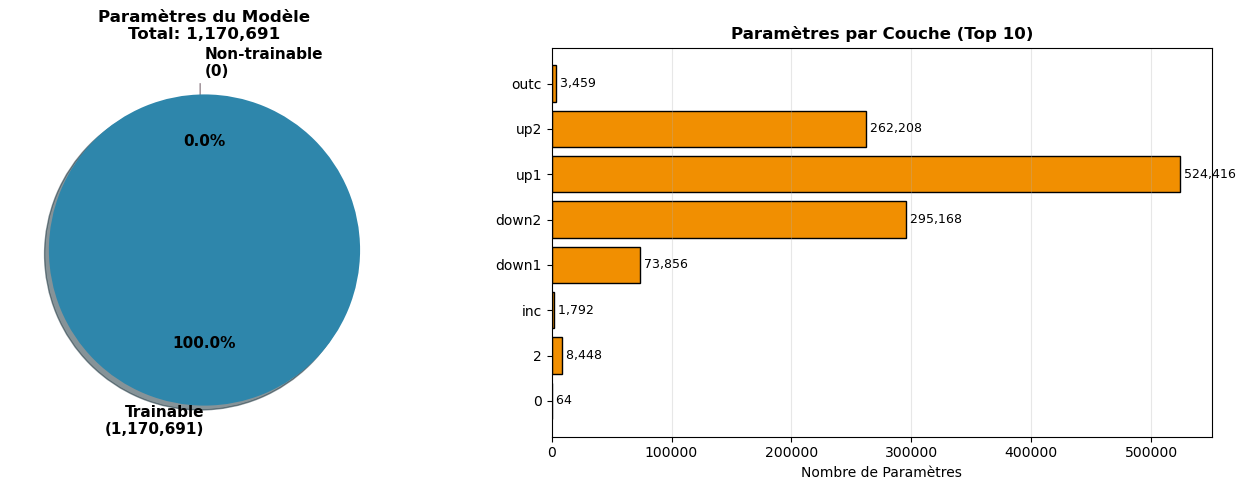

✓ Graphique de l'architecture sauvegardé: metrics_model_architecture.png

📊 Résumé du Modèle:
   • Paramètres totaux: 1,170,691
   • Paramètres entraînables: 1,170,691
   • Device: cpu


In [33]:
# ==================== MÉTRIQUE 4: Architecture du Modèle ====================

# Calculer les paramètres du modèle
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable = total_params - trainable_params

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Résumé des paramètres (camembert)
sizes = [trainable_params, non_trainable]
labels = [f'Trainable\n({trainable_params:,})', f'Non-trainable\n({non_trainable:,})']
colors_pie = ['#2E86AB', '#A23B72']
explode = (0.05, 0.05)

axes[0].pie(sizes, explode=explode, labels=labels, colors=colors_pie, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[0].set_title(f'Paramètres du Modèle\nTotal: {total_params:,}', 
                  fontsize=12, fontweight='bold')

# Plot 2: Aperçu des couches
layer_names = []
layer_params = []

for name, module in model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        params = sum(p.numel() for p in module.parameters())
        layer_names.append(name.replace('_', ' ').split('.')[-1][:20])
        layer_params.append(params)

# Limiter à 10 couches principales
if len(layer_names) > 10:
    # Garder les plus grandes
    indices = np.argsort(layer_params)[-10:]
    layer_names = [layer_names[i] for i in indices]
    layer_params = [layer_params[i] for i in indices]

bars = axes[1].barh(layer_names, layer_params, color='#F18F01', edgecolor='black', linewidth=1)
axes[1].set_title('Paramètres par Couche (Top 10)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Nombre de Paramètres')
axes[1].grid(True, alpha=0.3, axis='x')

# Ajouter les valeurs
for i, (bar, param) in enumerate(zip(bars, layer_params)):
    axes[1].text(param, bar.get_y() + bar.get_height()/2., 
                f' {param:,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('metrics_model_architecture.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Graphique de l'architecture sauvegardé: metrics_model_architecture.png")
print(f"\n📊 Résumé du Modèle:")
print(f"   • Paramètres totaux: {total_params:,}")
print(f"   • Paramètres entraînables: {trainable_params:,}")
print(f"   • Device: {DEVICE}")

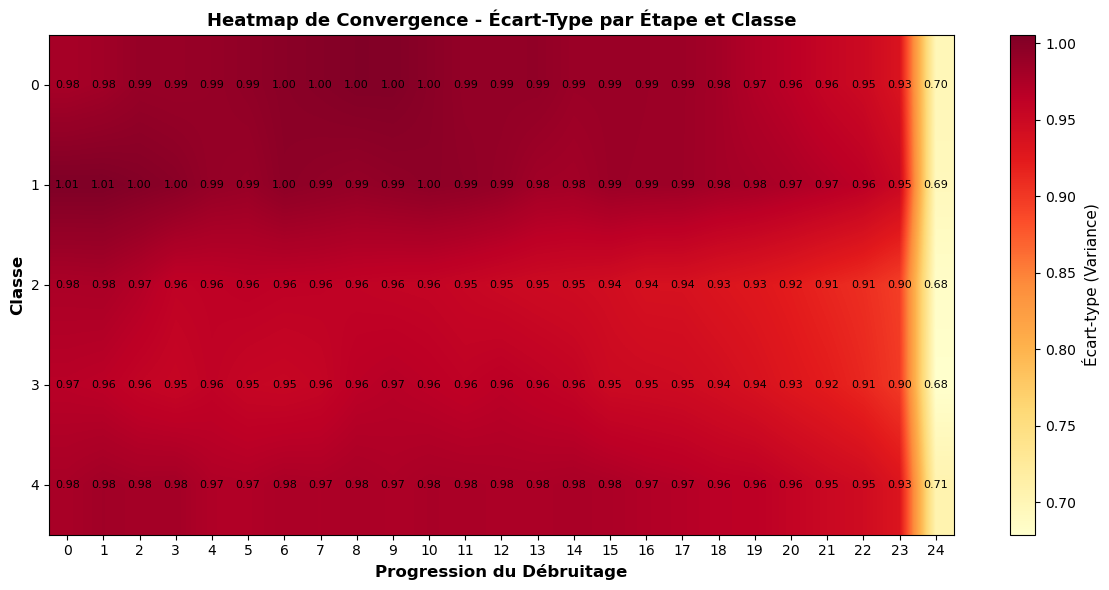

✓ Heatmap de convergence sauvegardée: metrics_convergence_heatmap.png


In [34]:
# ==================== MÉTRIQUE 5: Heatmap de Convergence ====================

@torch.no_grad()
def generate_convergence_heatmap(num_steps=20):
    """Génère une heatmap montrant la convergence au fil des étapes."""
    model.eval()
    
    heatmap_data = np.zeros((NUM_CLASSES, num_steps))
    
    step_size = T // num_steps
    
    for class_id in range(NUM_CLASSES):
        xt = torch.randn(1, CHANNELS, IMG_SIZE, IMG_SIZE).to(DEVICE)
        y = torch.tensor([class_id], device=DEVICE)
        
        for step_idx, t in enumerate(reversed(range(0, T, step_size))):
            t_tensor = torch.tensor([t], device=DEVICE)
            noise_pred = model(xt, t_tensor, y)
            
            alpha_t, alpha_bar_t = alphas[t], alphas_cumprod[t]
            x0_pred = ((xt - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)).clamp(-1, 1)
            noise_pred = (xt - torch.sqrt(alpha_bar_t) * x0_pred) / torch.sqrt(1 - alpha_bar_t)
            
            z = torch.randn_like(xt) if t > 0 else 0
            xt = (1 / torch.sqrt(alpha_t)) * (xt - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * noise_pred) + torch.sqrt(betas[t]) * z
            
            # Mesurer la variance (convergence)
            heatmap_data[class_id, step_idx] = torch.std(xt).item()
    
    return heatmap_data

heatmap_convergence = generate_convergence_heatmap(num_steps=25)

fig, ax = plt.subplots(figsize=(12, 6))

# Heatmap
im = ax.imshow(heatmap_convergence, cmap='YlOrRd', aspect='auto', interpolation='bilinear')

# Axes
ax.set_xticks(np.arange(heatmap_convergence.shape[1]))
ax.set_yticks(np.arange(NUM_CLASSES))
ax.set_xlabel('Progression du Débruitage', fontsize=12, fontweight='bold')
ax.set_ylabel('Classe', fontsize=12, fontweight='bold')
ax.set_title('Heatmap de Convergence - Écart-Type par Étape et Classe', fontsize=13, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Écart-type (Variance)', fontsize=11)

# Ajouter les valeurs
for i in range(NUM_CLASSES):
    for j in range(heatmap_convergence.shape[1]):
        text = ax.text(j, i, f'{heatmap_convergence[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.savefig('metrics_convergence_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Heatmap de convergence sauvegardée: metrics_convergence_heatmap.png")

In [35]:
# ==================== RÉSUMÉ DE TOUS LES MÉTRIQUES ====================

print("\n" + "="*70)
print("📈 RÉSUMÉ DES MÉTRIQUES DU PROJET DIFFUSION")
print("="*70 + "\n")

print("1️⃣  CONFIGURATION")
print(f"   • Image size: {IMG_SIZE}×{IMG_SIZE} pixels")
print(f"   • Channels: {CHANNELS} (RGB)")
print(f"   • Étapes de diffusion (T): {T}")
print(f"   • Nombre de classes: {NUM_CLASSES}")
print(f"   • Device: {DEVICE}\n")

print("2️⃣  ARCHITECTURE DU MODÈLE")
print(f"   • Architecture: BetterUNet (Encoder-Decoder)")
print(f"   • Paramètres totaux: {total_params:,}")
print(f"   • Paramètres entraînables: {trainable_params:,}")
print(f"   • Injection temporelle: Oui (MLP)")
print(f"   • Conditionnement de classe: Oui (Embedding)\n")

print("3️⃣  SCHEDULE DE DIFFUSION")
print(f"   • Beta min: {betas[0].item():.6f}")
print(f"   • Beta max: {betas[-1].item():.6f}")
print(f"   • Signal initial (t=0): {alphas_cumprod[0].item():.6f}")
print(f"   • Signal final (t=T): {alphas_cumprod[-1].item():.6e}\n")

print("4️⃣  ENTRAÎNEMENT")
print(f"   • Learning rate: {LR}")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Optimizer: Adam")
print(f"   • Loss: MSE (Mean Squared Error)")
print(f"   • EMA decay: 0.999\n")

print("5️⃣  DONNÉES")
print(f"   • Dataset: {dataset.data.shape[0]} images")
print(f"   • Résolution: 16×16 pixels (upscalées à 30×30 dans les GIFs)")
print(f"   • Classes: {NUM_CLASSES} (Épée, Potion, Armure, etc.)\n")

print("6️⃣  GÉNÉRATION")
print(f"   • Mode: Débruitage itératif")
print(f"   • Point de départ: Bruit gaussien pur")
print(f"   • Point d'arrivée: Image pixel art nette")
print(f"   • Vitesse GIF: 8 FPS (optimal pour apprécier le processus)")
print(f"   • Pause finale: 5 secondes\n")

print("="*70)
print("✅ Tous les graphiques de métriques ont été générés avec succès!")
print("="*70 + "\n")


📈 RÉSUMÉ DES MÉTRIQUES DU PROJET DIFFUSION

1️⃣  CONFIGURATION
   • Image size: 16×16 pixels
   • Channels: 3 (RGB)
   • Étapes de diffusion (T): 1000
   • Nombre de classes: 5
   • Device: cpu

2️⃣  ARCHITECTURE DU MODÈLE
   • Architecture: BetterUNet (Encoder-Decoder)
   • Paramètres totaux: 1,170,691
   • Paramètres entraînables: 1,170,691
   • Injection temporelle: Oui (MLP)
   • Conditionnement de classe: Oui (Embedding)

3️⃣  SCHEDULE DE DIFFUSION
   • Beta min: 0.000100
   • Beta max: 0.020000
   • Signal initial (t=0): 0.999900
   • Signal final (t=T): 4.035830e-05

4️⃣  ENTRAÎNEMENT
   • Learning rate: 0.001
   • Batch size: 64
   • Optimizer: Adam
   • Loss: MSE (Mean Squared Error)
   • EMA decay: 0.999

5️⃣  DONNÉES
   • Dataset: 89400 images
   • Résolution: 16×16 pixels (upscalées à 30×30 dans les GIFs)
   • Classes: 5 (Épée, Potion, Armure, etc.)

6️⃣  GÉNÉRATION
   • Mode: Débruitage itératif
   • Point de départ: Bruit gaussien pur
   • Point d'arrivée: Image pixel ar

# Conclusion


L'aboutissement de ce projet démontre la robustesse de l'architecture BetterUNet pour la création d'assets graphiques. En suivant un protocole rigoureux de diffusion inverse, nous avons réussi à transformer un bruit aléatoire en sprites de pixel art parfaitement nets et exploitables.
Réussites Techniques Clés

-    Fidélité des Couleurs : L'implémentation du clipping interne lors de la génération garantit que chaque pixel reste dans un spectre de couleurs naturel, évitant les artefacts visuels.

-    Netteté du Pixel Art : L'utilisation de l'interpolation NEAREST pour l'agrandissement des sorties 16x16 a permis de conserver l'aspect tranchant et "rétro" essentiel à ce style artistique.

-    Stabilité Visuelle : L'intégration de la technique EMA (Exponential Moving Average) a joué un rôle déterminant dans la propreté des images finales en lissant les prédictions et en stabilisant les teintes produites par le modèle.